In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Import all required libraries for data processing, visualization, modeling, and evaluation.**

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.18.0


Explore the folder structure and count how many images there are in each class for each split.



In [13]:
# Define dataset paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Count images per class
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal, pneumonia

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training - Normal: {train_normal}, Pneumonia: {train_pneumonia}")
print(f"Validation - Normal: {val_normal}, Pneumonia: {val_pneumonia}")
print(f"Test - Normal: {test_normal}, Pneumonia: {test_pneumonia}")


Training - Normal: 1341, Pneumonia: 3875
Validation - Normal: 8, Pneumonia: 8
Test - Normal: 234, Pneumonia: 390


**Visualizing Image Samples**

Show four example images from each class to understand the data visually.



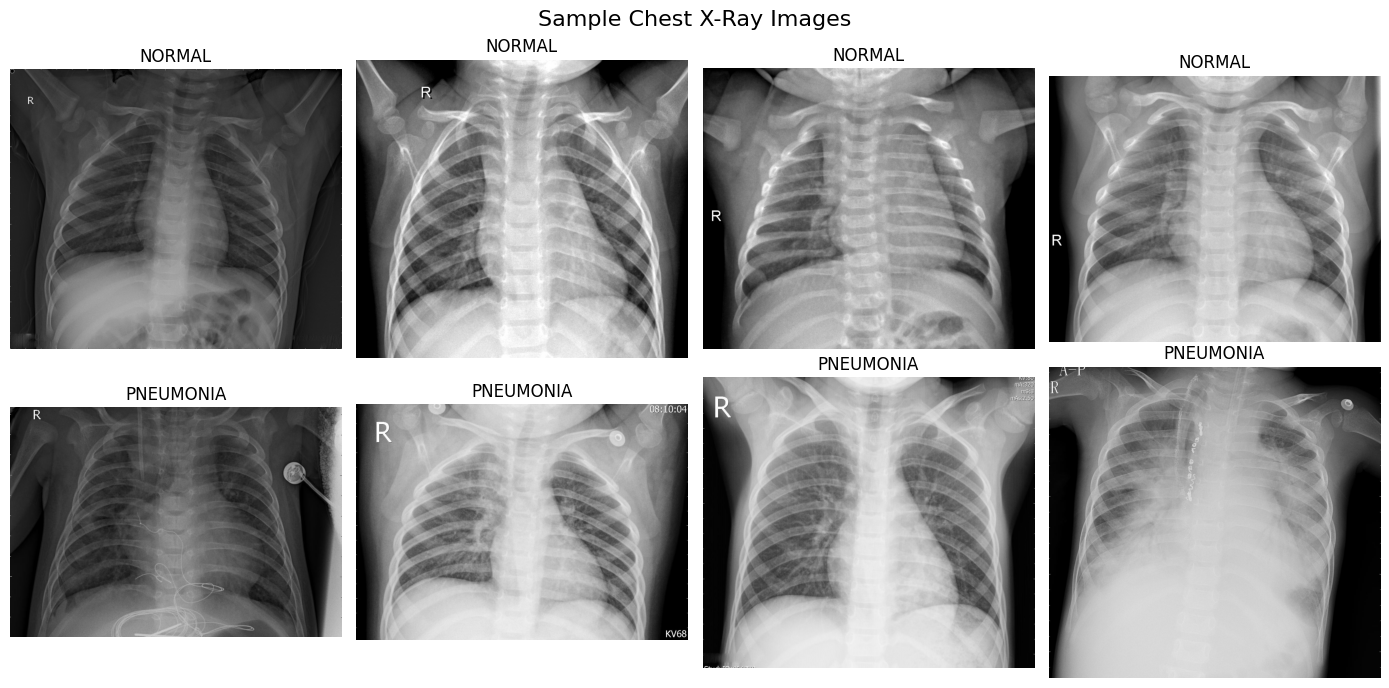

In [14]:
# Visualize sample images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Sample Chest X-Ray Images', fontsize=16)

normal_images = os.listdir(os.path.join(train_dir, 'NORMAL'))[:4]
pneumonia_images = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[:4]

for i, img_file in enumerate(normal_images):
    img_path = os.path.join(train_dir, 'NORMAL', img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title('NORMAL')
    axes[0, i].axis('off')

for i, img_file in enumerate(pneumonia_images):
    img_path = os.path.join(train_dir, 'PNEUMONIA', img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title('PNEUMONIA')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


**Data Preprocessing & Augmentation**
Resize images, normalize pixel values, and apply augmentation to the training set for better generalization. Validation and test data are only rescaled.




In [15]:
# Set image size and batch size
IMG_SIZE = 150
BATCH_SIZE = 32

# Train data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation & test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Defining the CNN Model**

Create a robust CNN architecture. BatchNormalization helps stabilize training, while Dropout combats overfitting.


In [16]:
# Building the convolutional neural network
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,944,961 (26.49 MB)

 Trainable params: 6,944,001 (26.49 MB)

 Non-trainable params: 960 (3.75 KB)

**Callbacks Setup**
Use EarlyStopping to prevent overfitting and ReduceLROnPlateau to dynamically reduce the learning rate for better convergence.



In [17]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

callbacks = [early_stopping, reduce_lr]


**Training the Model**

In [18]:
# Train the model
EPOCHS = 5

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7989 - loss: 1.2621 - val_accuracy: 0.5000 - val_loss: 23.8109 - learning_rate: 0.0010
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.8863 - loss: 0.4094 - val_accuracy: 0.5000 - val_loss: 34.4607 - learning_rate: 0.0010
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.8974 - loss: 0.2994 - val_accuracy: 0.5000 - val_loss: 7.6671 - learning_rate: 0.0010
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.9261 - loss: 0.2014 - val_accuracy: 0.5000 - val_loss: 7.5655 - learning_rate: 0.0010
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9253 - loss: 0.1897 - val_accuracy: 0.5000 - val_loss: 27.4516 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


**Visualizing Training History**

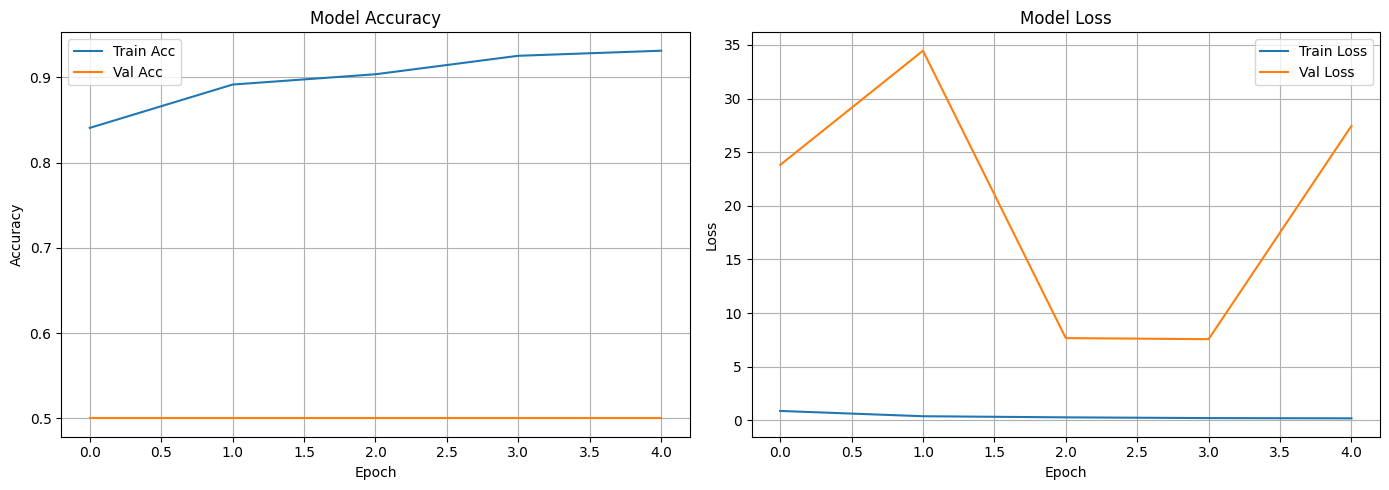

In [19]:
# Plot accuracy and loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Acc')
axes[0].plot(history.history['val_accuracy'], label='Val Acc')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Evaluate on Test Set**

In [20]:
# Evaluate performance on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Get predictions for test set
pred_probs = model.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 605ms/step - accuracy: 0.2984 - loss: 7.3319
Test Accuracy: 0.6250, Test Loss: 3.9892
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step


**Confusion Matrix**

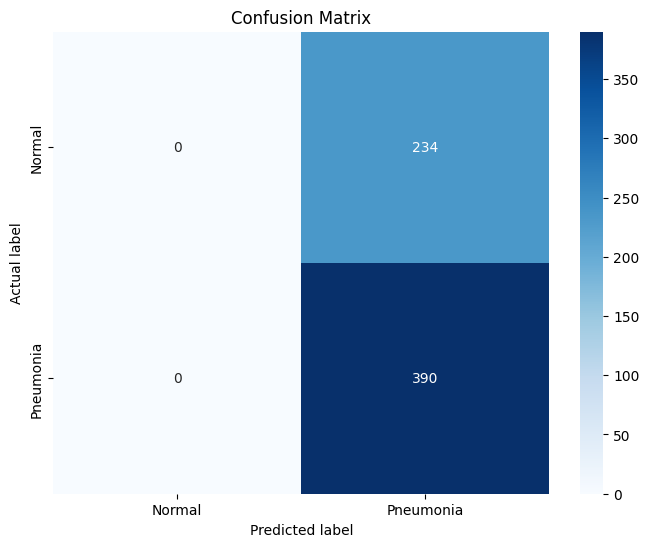

In [21]:
# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


**Classification Report**

In [22]:
# Print detailed metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ROC Curve**

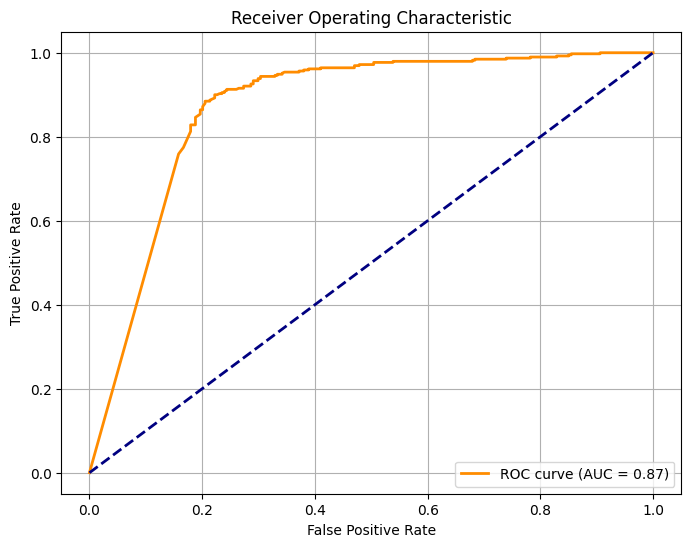

In [23]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
